In [1]:
# Basic math libraries
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import math
from matplotlib import pyplot as plt
import pickle
from matplotlib.colors import ListedColormap

# Matrix eigendecomposition
import numpy.linalg as lg
import scipy.linalg as slg

# Networks and Graphs
import networkx as nx
import dynetx as dn

# Random data generation
import itertools
import random
from collections import Counter
from random import randint
from itertools import chain
import time

# Neural Networks
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

%load_ext autoreload
%autoreload 2

# Import Network

In [3]:
# Import the multilayer dynamic network from file

L_file = np.load("datasets/outputs/multilayer_dynamic_network_500.npy", allow_pickle=True)
L_file = [[L_file[t][s] for s in range(len(L_file[0]))] for t in range(len(L_file))]


# Import node position to be used for all plots

pos_name = "kamada_kawai"
pos = np.load("datasets/nodes position for plot/position_network_" + pos_name + ".npy", allow_pickle=True).item()

In [4]:
# SET GRAPH NUMBERS

N = len(L_file[0][0])                                              # number of nodes
S = len(L_file[0])                                                 # number of layers (dyn + static)
layer_names = ['Hospital', 'Workplace', 'Random', 'School', 'Household']

T_file = len(L_file)
T_periodicity = 2
T = T_file * T_periodicity                                          # number of days 
L = L_file * T_periodicity

print("T =", T, "\nS =", S, "\nN =", N)

T = 56 
S = 5 
N = 500


In [5]:
# SET COVID NUMBERS

infection_threshold = 0.8                                     # signal value over which a person is considered sick
max_sickness_duration = 10                                    # days of maximum duration of the illness
min_immunization_duration = 60                                # days of immunization after having taken the virus


# import real covid cases and take the first T days
covid_cases = list(np.load("datasets/inputs/AI_covid_cases.npy", allow_pickle=True))[:T]

### Laplacian aggregation

just for representation purposes.

In [6]:
# Import the aggregated dynamic network from file

L_agg = np.load("datasets/outputs/aggregated_dynamic_network.npy", allow_pickle=True)
L_agg = [np.matrix(L_agg[t]) for t in range(len(L_agg))]
print(len(L_agg), L_agg[0].shape)

56 (500, 500)


# Signal inference problem

## T_0 signal

In [7]:
# Function to homogenize by window of lenght 3 the number of cases when loaded from online data

def homogenize_cases(cases_list):
    homogenized_cases = []
    for idx, val in enumerate(cases_list):
        if idx == 0 or idx == len(cases_list)-1:
            homogenized_cases.append(val)
        else:
            homogenized_cases.append( round(0.25*cases_list[idx-1] + 0.50*cases_list[idx] + 0.25*cases_list[idx+1]) )
    return homogenized_cases

In [8]:
# COVID DATA PREPARATION 

# homogenize the number of cases to adjust eventual test delays, and out only 1 case as starting diffusion point
numer_of_known_cases_day_by_day = homogenize_cases(covid_cases)
numer_of_known_cases_day_by_day[0] = 1

# # ALTERNATIVE: RANDOM GENERATION based on number of nodes N
# numer_of_known_cases_day_by_day = np.sort([randint(1, N) for p in range(0, T)]+[1])[0:T]
# numer_of_known_cases_day_by_day = [3,3,4,6,6,9,12,14,19,20,25,30, 34, 39, 40, 46, 52, 61, 74]

In [9]:
# First day signal

infected_t0 = random.sample(range(N), numer_of_known_cases_day_by_day[0])  
signal_t0 = np.zeros(N)
signal_t0[infected_t0] = 1    

print("Number of cases along ", T, " days: \n", numer_of_known_cases_day_by_day,
      "\n\nFirst nodes infected (at time t0): \n", infected_t0)

Number of cases along  56  days: 
 [1, 2, 4, 5, 5, 6, 6, 6, 6, 6, 8, 9, 11, 12, 13, 13, 14, 14, 16, 18, 20, 21, 21, 21, 22, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25] 

First nodes infected (at time t0): 
 [241]


## T_1,...T_n signals

The following process learns the best parameter tau for each combination of filters heat/normal/highpass in each layer. To learn the optimal combination and parameters, the class Learn_filter minimizes the temporal sum of:
  
\begin{equation}
abs( calculated\_n\_cases[t] - numer\_of\_known\_cases[t] )
\end{equation}

and returns the best filter with the best parameters. 

To unburden the computation, we decide to split the choice of the filter family and the learning of the parameters. Using the same algorithm, we first learn which family better describe the evolution of dynamic and static layers <b>over a smaller subset of layers</b> (eventually reducing the number of epochs). Then, fixed the filter families, we will learn the best tau parameters with a complete learning over all layers.

3 families of filters can be applied over the eigenvalues of each laplacian-layer (that arrives already regularized):
- HEAT with parameters tau
- NORMAL without parameters
- HIGHPASS with parameters tau

In [10]:
class Learn_Filter: 
    
    def __init__(self, epochs, lr):
        self.epochs = epochs
        self.lr     = lr
        
    def fit(self, tau, kind_of_filter, infection_threshold, numer_of_known_cases_day_by_day, signal_t0, L, print_epochs_each=25): 
        self.setup(tau, kind_of_filter, infection_threshold, numer_of_known_cases_day_by_day, signal_t0, L)
        self.train(print_epochs_each=25)                                   

    def setup(self, tau, kind_of_filter, infection_threshold, numer_of_known_cases_day_by_day, signal_t0, L):                                    
        self.tau = torch.from_numpy(tau.astype(np.float32)).requires_grad_()
        self.kind_of_filter = kind_of_filter
        self.infection_threshold = torch.tensor(infection_threshold)
        self.numer_of_known_cases_day_by_day = torch.tensor(numer_of_known_cases_day_by_day)
        self.signal_t0 = torch.from_numpy(signal_t0.astype(np.float32))
        self.L = [   [  torch.from_numpy(L[t][s].astype(np.float32)) for s in range(S)   ]  for t in range(T) ]
       
    def loss(self): 
        sum_loss = 0  
        signal_time = [self.signal_t0]
        sigmoid = nn.Sigmoid()

        for t in range(T):
            signal_time_t = self.NN_multilayer_evolution(signal_time, t)
            signal_time.append(signal_time_t)
            
            # Convert signal_time_t to bool without loosing gradient
            stretched = (signal_time_t-self.infection_threshold)*10000
            boolean = sigmoid(stretched)
            error = abs(torch.sum(boolean) - self.numer_of_known_cases_day_by_day[t])
            
            sum_loss += error
        return sum_loss
                      
    def train(self, print_epochs_each):
        optimizer = torch.optim.Adam( [self.tau], lr=self.lr, amsgrad=True) 
        self.history = []
        for epoch in range(self.epochs+1):
            loss = self.loss()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            self.history.append(loss.detach().item())            
            if epoch == 0 or epoch % print_epochs_each == 0:
                print('\nEpoch {:4d}/{:d}: {:2.2f}'.format(epoch, self.epochs, loss.item()))  
                print('Learning tau :', (self.tau).detach().numpy()) 
    
    def learned_tau(self):
        return (self.tau).detach().numpy()

    
#------------------------------Functions to calculate the filtering, converted to Torch------------------------------------------------
    
    def NN_h_filter(self, tau_nn, laplacian, kind_of_filter): 
        eigenvalues , eigenvectors = torch.eig(laplacian, eigenvectors = True)
        eigenvalues = eigenvalues[:, 0]
        if kind_of_filter == "heat":
            heat_diag = torch.exp(-eigenvalues*tau_nn)
            H_filter = torch.diag(heat_diag)
            h_filter = torch.matmul (torch.matmul(eigenvectors, H_filter) , eigenvectors.T)   
        elif kind_of_filter == "normal":                               # no tau to learn
            alpha = 0.01
            eigenv = torch.diag(eigenvalues) + alpha * torch.eye(len(eigenvalues)) 
            pseudo_inv = torch.inverse(eigenv)                             
            evals, evecs = torch.eig(pseudo_inv, eigenvectors = True)  # eigendecomposition to calculate matricial sqrt with torch
            evals = evals[:, 0]  
            square_root = torch.matmul(evecs, torch.matmul(torch.diag(evals**(-1/2)), torch.inverse(evecs)))  
            square_root = square_root + tau_nn*0                       # workaround
            h_filter = torch.matmul( torch.matmul(eigenvectors, square_root) , eigenvectors.T) 
        elif kind_of_filter == "highpass":
            alpha = 0.01 
            numerator = torch.diag(eigenvalues)*tau_nn
            denominator = torch.inverse(torch.diag( torch.exp(-(eigenvalues+1)*tau_nn) )+ alpha * torch.eye(len(eigenvalues)) )
            H_filter = torch.matmul(numerator,denominator)
            h_filter = torch.matmul( torch.matmul(eigenvectors, H_filter) , eigenvectors.T)     
        return h_filter

    def NN_single_layer_evolution(self, tau_nn, input_signal, kind_of_filter, L):

        filtered_signal = torch.matmul( self.NN_h_filter(tau_nn, L, kind_of_filter), input_signal) 
        min_v = torch.min(filtered_signal)
        max_v = torch.max(filtered_signal)
        if min_v==max_v:       # to avoid denominator=0 that gives NaN
            normalized_signal = (filtered_signal - min_v)
        else:
            normalized_signal = (filtered_signal - min_v) / (max_v-min_v)   
        return normalized_signal   
    

    def NN_multilayer_evolution(self, signal_multilayer_temporal, t):        
        
        signal_multilayer = []
        
        for s in range(S):

            signal_layer = self.NN_single_layer_evolution(self.tau[s], signal_multilayer_temporal[t], self.kind_of_filter[s], self.L[t][s])  
            signal_multilayer.append(signal_layer)
            
        for n in range(N):
            
            # Select the worst health status of the person over all layers
            max_value =  max( [signal_multilayer[l][n] for l in range(S)] )           
            if n == 0:
                max_signal =  torch.unsqueeze(max_value, 0)
            else:    
                max_signal = torch.cat((max_signal, torch.unsqueeze(max_value, 0)), dim=0) 
                               
            # One cannot be infectuous for more than tot. days (tot.= max_sickness_duration)
            if t>max_sickness_duration and signal_multilayer_temporal[t-max_sickness_duration+1][n] > self.infection_threshold:
                max_value = 0 
            
            # After having COVID, one is immune for at least tot. days (tot.= min_immunization_duration)
            if t>min_immunization_duration \
            and any([signal_multilayer_temporal[t-i][n]>self.infection_threshold for i in range(min_immunization_duration)]) \
            and signal_multilayer_temporal[t][n] < self.infection_threshold: 
                max_value = 0 
                
        return max_signal

### Learn TAU parameters

In [ ]:
# Learn the tau that better define a diffusion coherent with the real number of COVID cases, over all the timestamps


# params initialization

kind_of_filter = ["heat"]*S
tau = np.ones(S)/S
# kind_of_filter = list(df[layer_names[:S]].iloc[0])       # from the first line of the df
# tau = list(df["Tau"].iloc[0])                            # from the first line of the df
T = T_file * T_periodicity  

# NN creation and learning

print("time before:", time.ctime())
net_cases = Learn_Filter(epochs=500, lr=0.007)
net_cases.fit(tau, kind_of_filter, infection_threshold, numer_of_known_cases_day_by_day, signal_t0, L, print_epochs_each=25)
tau = net_cases.learned_tau()
print("time after:", time.ctime())

time before: Sat Mar 20 23:34:00 2021

Epoch    0/500: 2255.83
Learning tau : [0.207 0.207 0.193 0.207 0.193]

Epoch   25/500: 2194.99
Learning tau : [0.2738907  0.31208834 0.21444364 0.14208575 0.0482871 ]

Epoch   50/500: 1286.51
Learning tau : [0.19558474 0.29632127 0.1532969  0.01145276 0.02681011]


In [12]:
tau = [0.27755243, 0.09961079, 0.16747989, 0.03570133, 0.24148309]

In [13]:
# Print TAU results

print("The filters and parameters Tau better representing diffusion processes over each layer are:\n")
for i, name in enumerate(layer_names):  
    print(kind_of_filter[i], "filter with Tau =", tau[i], " for layer " + name)

The filters and parameters Tau better representing diffusion processes over each layer are:

heat filter with Tau = 0.27755243  for layer Hospital
heat filter with Tau = 0.09961079  for layer Workplace
heat filter with Tau = 0.16747989  for layer Random
heat filter with Tau = 0.03570133  for layer School
heat filter with Tau = 0.24148309  for layer Household


### Generate temporal signal

NEXT DAYS: we generate the next-days signals as filtered version of the initial signal. This imitates a diffusion
over the graph. The filter family have been learned before, here we learn better parameters tau to balance the numer_of_known_cases_day_by_day.
NB: The signals generated like this are destinated to disappear along time, so in the algorithm we constantly rescale to have peaks close to 1.

In [14]:
def h_filter(laplacian, kind_of_filter, tau, **params):
    eigenvalues , eigenvectors = lg.eigh(laplacian)    #scipy.linalg.eigh(laplacian)
   
    if kind_of_filter not in ("heat", "normal", "highpass"):
        print("kind_of_filter must be chosen between: normal, heat, highpass")
        return 0

    elif kind_of_filter == "heat":
        heat_diag = [np.exp(-tau*x) for x in eigenvalues]
        H_filter = np.diag(heat_diag)
        h_filter = eigenvectors.dot(H_filter).dot(eigenvectors.T)
   
    elif kind_of_filter == "normal":  
        alpha = 0.01
        eigenv = np.diag(eigenvalues) + alpha * np.eye(len(eigenvalues))  # regularization term, to avoid 0 values in the sqrt
        x_reg = lg.pinv(eigenv)
        h_filter = eigenvectors.dot(slg.sqrtm(x_reg)).dot(eigenvectors.T)
       
    elif kind_of_filter == "highpass":
        numerator = np.diag(eigenvalues)*tau
        denominator = lg.pinv(np.diag( [tau*x+1 for x in eigenvalues] ))
        H_filter = numerator.dot(denominator)
        h_filter = eigenvectors.dot(H_filter).dot(eigenvectors.T)
        
    return h_filter  

In [15]:
# Calculate the next-day signal over the multi layer graph. The inputs L and tau are lists.
# Performs RESCALING of high values (with a threshold) and a limit to SICKNESS DURATION (set to 10 days). 

def single_layer_evolution(input_signal, kind_of_filter, L, tau, infection_threshold, **params):
    filtered_signal = h_filter(L, kind_of_filter, tau, **params).dot(input_signal) 
    new_signal = np.interp(filtered_signal, (filtered_signal.min(), filtered_signal.max()), (0, +1))             
    return np.array(new_signal)      


def multilayer_evolution(input_signal, kind_of_filter, L, tau, infection_threshold, **params):
    signal_multilayer_temporal = [input_signal]
    bool_signal_multilayer_temporal = [input_signal]
    
    for t in range(T-1):          
        # calculate the signal over each layer, at each timestamp t
        signal_multilayer = []  
        for s in range(S):
            signal_layer = single_layer_evolution(signal_multilayer_temporal[t], kind_of_filter[s], L[t][s], tau[s], infection_threshold,  **params)  
            signal_multilayer.append(signal_layer)
            
        # select the maximum value above layers
        max_signal = []
        bool_max_signal = []
        for n in range(len(input_signal)): 
            max_value =  max( [signal_multilayer[s][n] for s in range(S)] )
            bool_max_value = 0
            
            # Threshold and Immunization lenght application
            if max_value > infection_threshold:
                bool_max_value = 1
            if t>max_sickness_duration and bool_signal_multilayer_temporal[t-max_sickness_duration+1][n] == 1: 
                max_value = 0 
                bool_max_value = 0
            if t>min_immunization_duration \
            and sum([bool_signal_multilayer_temporal[t-i][n] for i in range(min_immunization_duration)]) > 0 \
            and bool_signal_multilayer_temporal[t][n] == 0: 
                max_value = 0 
                bool_max_value = 0
            max_signal.append(max_value)  
            bool_max_signal.append(bool_max_value)
    
        signal_multilayer_temporal.append(np.array(max_signal)) 
        bool_signal_multilayer_temporal.append(np.array(bool_max_signal))
    return np.array(signal_multilayer_temporal), np.array(bool_signal_multilayer_temporal)

In [16]:
# Calculation of the diffusion using the parameters learned above

print("Learning diffusion with the filters:", kind_of_filter)
signal_time, bool_signal_time = multilayer_evolution(signal_t0, kind_of_filter, L, tau, infection_threshold)

Learning diffusion with the filters: ['heat', 'heat', 'heat', 'heat', 'heat']


### Plot

In [24]:
# Graph visualization of infection spread in picked days, over individual layers or the aggregated one.

def graph_diffusion_Lagg(Lap, signal_time, bool_signal_time, n_snapshots_to_print, pos=None): 
    
    days_to_display = [round( (T)*i/(n_snapshots_to_print-1)) for i in range(0, n_snapshots_to_print-1)] + [T-1]
    days_to_display.sort()
    
    for i, signal in enumerate([signal_time, bool_signal_time]):
        fig, axes = plt.subplots(nrows=1, ncols=len(days_to_display), figsize = [18, 4])
        ax = axes.flatten()   
        
        for idx, val in enumerate(days_to_display):
            graph_to_display = graph_from_laplacian(Lap[val])
            if idx==0 and pos is None:
                pos=nx.spring_layout(graph_to_display)
            if i==0:
                ax[idx].set_title("Infection at day:"+str(val), fontsize=13)
            if idx==0 and i==0:
                ax[idx].set_ylabel("Decimal signal", {'fontsize': 20}) 
            if idx==0 and i==1:
                ax[idx].set_ylabel("Binary signal", {'fontsize': 20})
            ax[idx].axis('off')
            edges,w = zip(*nx.get_edge_attributes(graph_to_display,'weight').items())
            emap = plt.cm.Greys # ListedColormap([(0,0,0)])
            nx.draw_networkx_nodes(graph_to_display, pos, node_size=50, node_color=signal[val], ax=ax[idx]) 
            nx.draw_networkx_edges(graph_to_display, pos, width=0.5, edgelist=edges, edge_color=w, edge_cmap=emap, alpha=0.25, ax=ax[idx])
    plt.show() 
    

def graph_from_laplacian(L):
    A = -L
    np.fill_diagonal(A, 0)
    A_ = np.maximum(A, 0)
    G = nx.from_numpy_matrix(A_)
    return G

/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/home/cozzani/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstanc

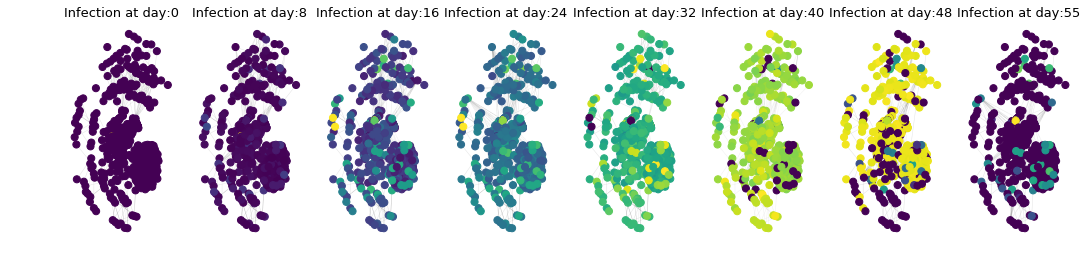

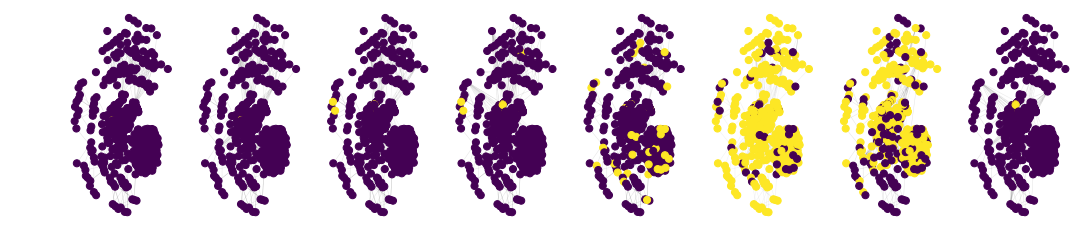

In [25]:
# Graph representation of the binary signal over the aggregated laplacian

n_snapshots_to_print = 8
graph_diffusion_Lagg(L_agg, signal_time, bool_signal_time, n_snapshots_to_print, pos=pos)

# Evaluation and observations

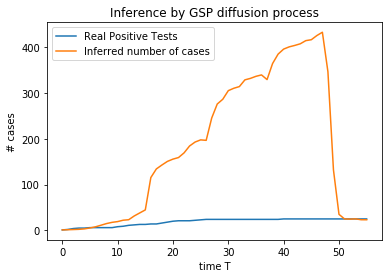

In [26]:
plt.plot(numer_of_known_cases_day_by_day, label="Real Positive Tests")
plt.plot([sum(signal) for signal in signal_time], label="Inferred number of cases")
plt.xlabel('time T')
plt.ylabel('# cases')
plt.title('Inference by GSP diffusion process')
plt.legend()
plt.show()

In [36]:
cases_comparison = pd.DataFrame(numer_of_known_cases_day_by_day, columns = ['real'])
cases_comparison['inferred'] = [int(sum(x)) for x in bool_signal_time]
cases_comparison

,real,inferred
0,1,1
1,2,1
2,4,1
3,5,1
4,5,3
5,6,3
6,6,3
7,6,3
8,6,3
9,6,3


As expected, forcing the phenomena to a diffusion process, it is clear that Covid tests are incomplete meaning that there is more people infected that has not been detected. Even if our tool depend on a synthetically cerated network and the starting point is random, just looking at numbers it come clear that the number of tests not only depend on the period (availability of tests) but also is never corresponding to the daily number of infected people. To have such a result in fact, there would be to test all population every day, and this is of course not realistic.

# Save Signals in file

In [27]:
# Save the signals as list of signals in a .npy file

inferred_signal = [signal_time, bool_signal_time]
np.save("datasets/outputs/inferred_signal.npy", inferred_signal)

In [28]:
# Save filter names and values of parameters Tau

inferred_filters_and_tau = [kind_of_filter, tau]
np.save("datasets/outputs/inferred_filters_and_tau.npy", np.array(inferred_filters_and_tau, dtype=object))